In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))
test_label = test[:, 0]

In [4]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

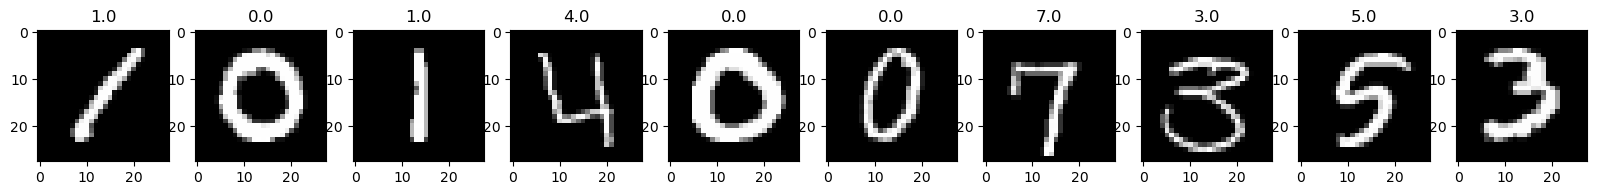

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:10], 1):
    subplot = fig.add_subplot(1, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [6]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [7]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [8]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [9]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

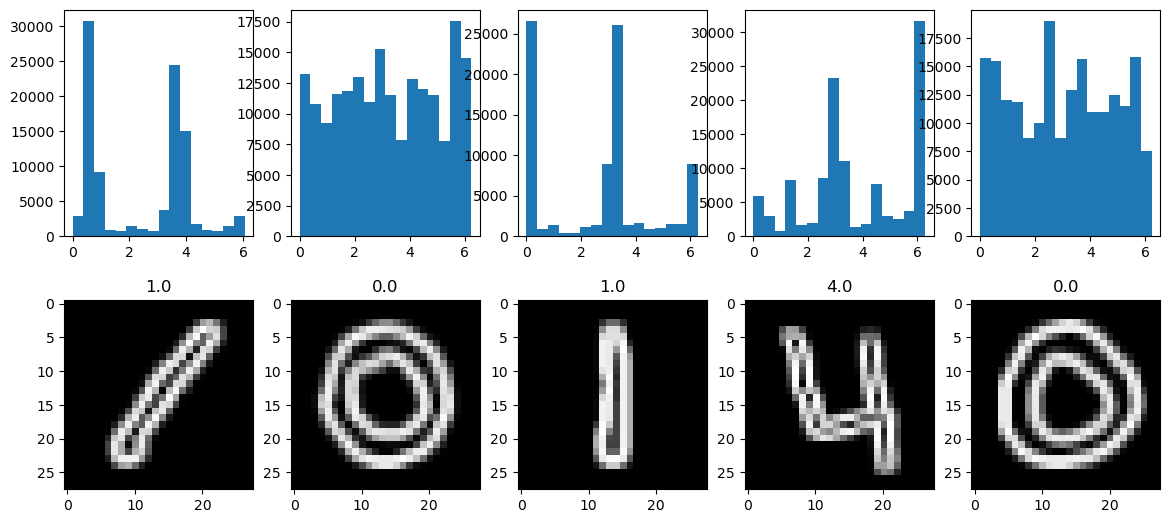

In [10]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [11]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [12]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [13]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [14]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Задаем параметры для вычисления дескриптора

In [15]:
winSize = (28,28)
blockSize = (14,14)
blockStride = (14,14)
cellSize = (7,7)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64

## Создаем объект HOGDescriptor с заданным параметрами

In [16]:
hog = cv2.HOGDescriptor(winSize,
                          blockSize,
                          blockStride,
                          cellSize,
                          nbins,
                          derivAperture,
                          winSigma,
                          histogramNormType,
                          L2HysThreshold,
                          gammaCorrection,
                          nlevels)

In [17]:
train_descriptors = np.zeros((len(train_img), 144))
for i in range(len(train_img)):
    train_descriptors[i] = hog.compute(np.uint8(train_img[i])).reshape(-1)

## Разбиваем выборку на обучение и валидацию

In [18]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_descriptors, test_size=0.2,
    random_state=42)

### Используем модель RandomForestClassifier

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
model_ = RandomForestClassifier(random_state=42)

In [21]:
model_.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [22]:
from sklearn.metrics import accuracy_score

pred_val = model_.predict(x_val)

print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.9682142857142857


#### Accuracy: 0.9682142857142857

In [27]:
test_descriptors = np.zeros((len(test_img), 144))
for i in range(len(test_img)):
    test_descriptors[i] = hog.compute(np.uint8(test_img[i])).reshape(-1)

In [28]:
y_predict_test_ = model_.predict(test_descriptors)
y_predict_test_ = y_predict_test_.astype(np.uint8)

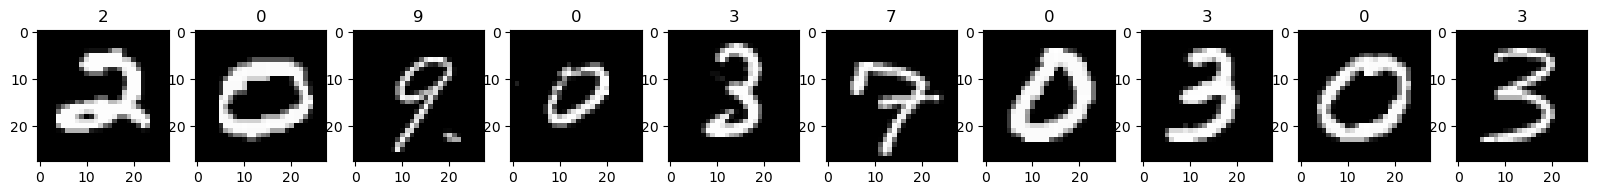

In [29]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:10], 1):
    subplot = fig.add_subplot(1, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % y_predict_test_[i - 1])

### Используем модель SVC

In [30]:
from sklearn.svm import SVC

In [31]:
model = SVC(kernel='linear', C=1.0, random_state=42)

In [32]:
model.fit(x_train, y_train)

SVC(kernel='linear', random_state=42)

In [33]:
from sklearn.metrics import accuracy_score

pred_val = model.predict(x_val)

print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.974047619047619


#### Accuracy: 0.974047619047619

In [34]:
test_descriptors = np.zeros((len(test_img), 144))
for i in range(len(test_img)):
    test_descriptors[i] = hog.compute(np.uint8(test_img[i])).reshape(-1)

In [35]:
y_predict_test = model.predict(test_descriptors)
y_predict_test = y_predict_test.astype(np.uint8)

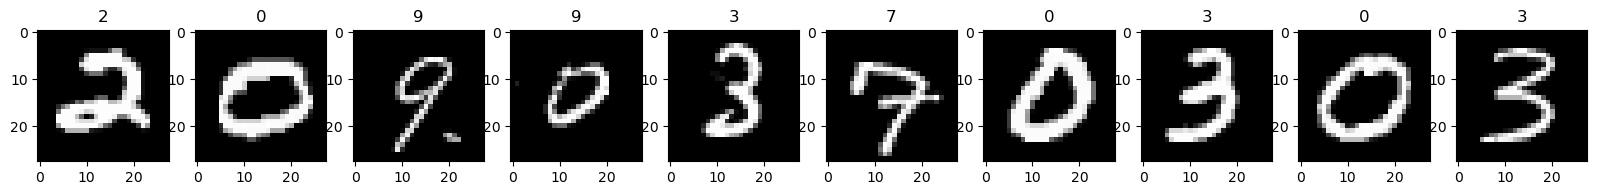

In [36]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:10], 1):
    subplot = fig.add_subplot(1, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % y_predict_test[i - 1])

## Готовим файл для отправки

In [43]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_predict_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [45]:
import pandas as pd
df=pd.read_csv('submit.txt', sep=',')

df['Label'] = df['Label'].apply(lambda x: int(x))
df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [46]:
df.to_csv('submit.csv', index=False)

In [57]:
from PIL import Image
image = Image.open('res.jpg')

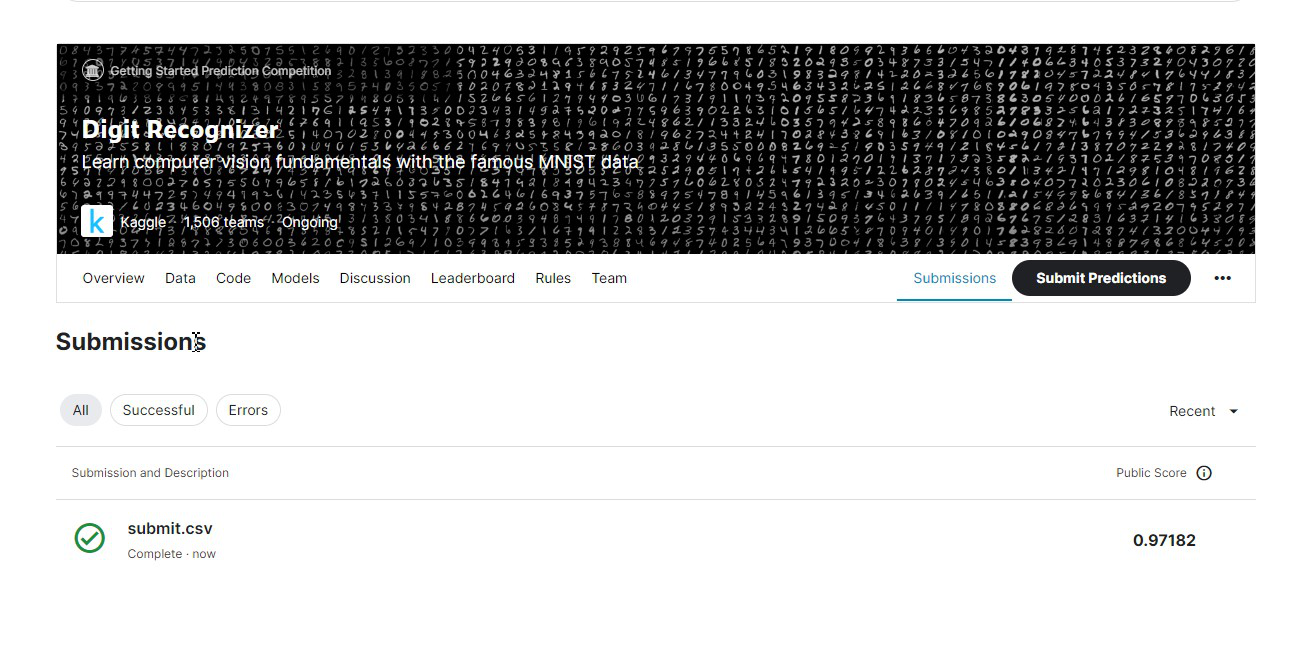

In [58]:
image